In [1]:
import matplotlib.pyplot as plt
from math import *
import numpy as np
import os
from scipy.stats import nanmean

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
%matplotlib inline

## Original

In [3]:
def tanktopo(total_fluid_depth,y,y_base,y_bc,y_sb,y_coast,z_bottom,z_bc,z_sb,z_wall):
    """ Finds the topography in the tank without the canyon
    finds points at different parts of the topography using the equation of the liney=mx+b
    where topo_sp = y = mx+yo-mxo the values in the y & z are the corresponding bathymetry lines"""
    
    # The values below are specific to the outer canyon slope & used only here
  
    ys_200 = 49770 #y_wall-(0.44956*y_wall);
    ys_400 = 41100 #y_wall-(0.64222*y_wall);
    ys_600 = 35900 #y_wall-(0.75778*y_wall);
  
    #The slopes indicates the slope from the point below to the point indictaed
    #in the value name (i.e. sls_50 is the slope from ys_tops to ys_50, etc...
   
    sls_coast = 0.003
    sls_50 = 0.00618
    sls_100 = 0.01018
    sls_sb = 0.034
    sls_bc = 0.2439
   
    topo_sp = np.zeros(len(y))
    slope_profile = np.zeros(len(y))
   
    for jj in np.arange(len(y)):
     
        if y[jj] > y_base and y[jj]<= y_bc: # * cross-shore between slope bottom and  canyon mouth
            topo_sp[jj] = sls_bc*y[jj]+ z_bottom - sls_bc*y_base
                    
        elif y[jj]> y_bc and y[jj]<= y_sb: # * cross-shore between canyon mouth and shelf break?!
            topo_sp[jj] = sls_sb*y[jj] + z_bc - sls_sb*y_bc
                   
        elif y[jj]> y_sb and y[jj] < y_coast: # * cross-shore between shelf break and shelf now flat
            topo_sp[jj] = 0.00614*y[jj] + z_sb - 0.00614*y_sb
                                  
        elif y[jj]>= y_coast: # * anything beyond point where shelf is flat
            topo_sp[jj] = z_wall
                
    # subtract total fluid depth
    slope_profile[jj] = topo_sp[jj]-total_fluid_depth
  
    return slope_profile

In [4]:
def canyontopo(total_fluid_depth, L, y, y_sb, y_coast, z_sb, z_wall):
    """ define shelf/slope radii, creates the slope of inside the canyon
    the input variables can be seen in the main function description"""
    
    topo_cp = np.zeros(len(y))
    canyon_profile = np.zeros(len(y))
    
    y_L = y_sb+L 
    yc_1100 = 51220
    yc_1000 = 54030
    yc_1200 = 40700 #48650 NWcanyon #40700 Barkley, 50500 Jessica's
    
    for ii in np.arange(len(y)):
    
        if y[ii] <= yc_1200:
            topo_cp[ii] = 0

        elif y[ii] > yc_1200 and y[ii]<= y_L: #yc_1000:
            topo_cp[ii] = 0.0621301775*y[ii] + 0 - 0.0621301775*yc_1200

        elif y[ii] > y_L and y[ii] < y_coast :      
            topo_cp[ii] = 0.026*y[ii] + z_sb - 0.026*y_L #0.26

        elif y[ii] >= y_coast:
            topo_cp[ii] = z_wall

        # subtract total fluid depth
        canyon_profile[ii] = topo_cp[ii]-total_fluid_depth
 
    return canyon_profile

In [5]:
#def widthprofile(cR,W,Wsb,L,p,y,y_base,y_sb):
def widthprofile(W,Wsb,L,p,y,y_base,y_sb):
    """ define shelf/slope radii (should be same as canyontopo above)
    define shape of topography (in m)
    the input variables can be seen above in the main function description"""
    
    """I removed cR from function arguments."""
    
    # Set values for the width profile
    # calculate derived numbers to help shape the canyon
  
    #sigmaa = 1.0/((9e-7)*cR)
    sigmaa = 0
    half = -Wsb/2.0+W/2.0 # width halfway between W and Wsb
    e = (L/2.0 -sigmaa*half**2)/half**p
    
    # scale factor
    sc = 1
    
    # fudge down to the deep
    alphaa = y_sb/y_base
    
    #The following sets of values correspond to width measurements from figure
    #1 of Flexxas et al., 2008
    #The 15 to 1 values indicate the approximate distance from the canyon head
    #(in km)
    #y90 is slightly less than the distance 10% from the canyon mouth 
    
    #This value is the newer (smaller) width at the canyon mouth; used for
    #smoothing the overall canyon width
    
    y90 = y_sb+0.062423*L
    W90 = Wsb-0.06651*Wsb
    dG_dx90 = p*e*(W90 - Wsb/2)**(p - 1) + 2*sigmaa*(W90 - Wsb)
    dW90 = 0.5/dG_dx90/sc
    A90 = (alphaa*Wsb-W90)/(y_base-y90)**2 - dW90/(y_base-y90)
    
    Wh = Wsb-0.9705*Wsb
    dG_dxh = p*e*(Wh - Wsb/2)**(p - 1) + 2*sigmaa*(Wh - Wsb)
    dh = 0.5/dG_dxh/sc
    Ah = (alphaa*Wsb-Wh)/(y_base-(y_sb+L))**2; #- dh/(y_base-(y_sb+L))
    
    wp = np.zeros(len(y))
    
    for l in np.arange(len(y)):
    
        if y[l] <= y_base:
            wp[l] = Wsb*alphaa + 9000
            
        elif y[l] > y_base and y[l] <= y_sb+L:
            wp[l] = Ah*(y[l]-(y_sb+L))**2 + dh*(y[l]-(y_sb+L))+Wh + 9000
               
        elif y[l] >= y_sb + L: # greater than canyon head
            wp[l] = 9390
        
    width_profile = wp  
    #width profile works smoothest with Y_base -> y_sb+L (using "head" terms)
    #-> >y_sb+L
   
    return width_profile

In [6]:
#def make_arbitrary_topo_smooth(total_fluid_depth,cR,W,Wsb,L,p,x,x_wall,y,y_base,y_bc,y_sb,y_coast,z_bottom,z_bc,z_sb,z_wall):
def make_arbitrary_topo_smooth(total_fluid_depth,W,Wsb,L,p,x,x_wall,y,y_base,y_bc,y_sb,y_coast,z_bottom,z_bc,z_sb,z_wall):
    """This function was originally written for python, then translated to matlab.
    I took the matlab version form Jessica Spurgin's files for MITgcm: This is a 
    function that will return a depth field (topography) with a sech-shaped canyon:
    
    :arg total_fluid_depth: the depth of the fluid or the total depth
    :arg y_wall: the length of the ocean basin (y-axis)(going from 0=deep ocean m high values = coast
    :arg x_wall: the width of the ocean basin (x-axis)
    :arg y_base: the distance where the slope begins to rise from the bottom
    :arg y_bc: the distance to the canyon mouth
    :arg y_sb: the distance of the shelf break
    :arg y_100: the distance to the 100m isobath
    :arg y_50: the distance to the 50m isobath
    :arg y_coast: the distance to the "coast" where topography stops increasing, but 	depth NOT =0
    :arg z_bottom: depth of the "deep ocean"; z is measured from the bottom up
    :arg z_bc: depth of the 1000 m contour
    :arg z_800: depth of the 800 m contour
    :arg z_600: depth of the 600 m contour
    :arg z_400: depth of the 400 m contour
    :arg z_200: depth of the 200 m contour
    :arg z_sb: shelf break depth (150m)
    :arg z_100: depth of the 100 m contour
    :arg z50: depth of the 50 m contour
    :arg z_wall: the depth of the topography beyond the y_coast variable (i.e. z_wall NOT = total fluid depth)
    :arg cR: the radius of curvature at the shelf break depth
    :arg W: the width at half the length at the shelf break depth
    :arg Wsb: the width at the shelf break
    :arg L: the length of the canyon
    :arg p,q: geometric parameters used to help shape the canyon see geometry.ods
    """
        
    # Slope profile is the topography without the canyon
    slope_profile = tanktopo(total_fluid_depth,y,y_base,y_bc,y_sb,y_coast,z_bottom,z_bc,z_sb,z_wall)
    
    # Canyon Profile defines the slope of the canyon
    canyon_profile = canyontopo(total_fluid_depth,L,y,y_sb,y_coast,z_sb,z_wall)
    
    # Width profile defines the slope of the canyon as well as the shape
    #width_profile = widthprofile(cR,W,Wsb,L,p,y,y_base,y_sb)
    width_profile = widthprofile(W,Wsb,L,p,y,y_base,y_sb)
    
    # finding the depth of the canyon and setting negative values to zero
    canyondepth = slope_profile - canyon_profile
    canyondepth[canyondepth < 0] = 0
    
    # putting everything together to get the topography of the tank with a sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    
    for j in np.arange(len(x)):
        # the width profile here is in m but in the python code it is in cm and
        # the coefficient is 45.5 instead of 0.455 I changed it so the units would work
        topography[:,j] = (slope_profile-canyondepth*(1.0/(np.cosh(0.455/width_profile*(x[j]-(0.5*x_wall))))**50))
    
    # Transposing the topography so that it is the same order as fortran reads
    # If this is not done the grid will not look right when implemented into the gcm
    #topography=np.transpose(topography)
   
    return topography

In [7]:
z_sb = 150 # depth at shelf break (--) * good
# depth at canyon head 30 m different for flat shelf where 150 m
# depth drop across canyon 950
z_bottom = 1200 # depth of basin (depth of deep ocean)
Wsb =  13005 # width at shelf break (--) * good
W = 7660 # width at mid-canyon (--) * good
L = 16180 # canyon length (--)
x_wall = 120 * 1000 # alongshore direction (width of the ocean basin) * good
y_wall = 90 * 1000 # cross-shore direction (length of the ocean basin)
y_base = 25 * 1000 # (distance where slope begins to rise from bottom) * ???? 25
y_bc = 52 * 1000 # (distance to canyon mouth) * NO EFFECT?
y_sb = 52 * 1000 # (distance to the shelf break) * makes the stem disappear when increased to 75 // y_wall - (45 * 1000)
y_coast = 59 * 1000 # (distance to where topo stops increasing but not 0) * shape of the stem // y_wall - (20 * 1000)
z_bc = 1000 # (depth of 1000 m contour) ???????????? any difference????
z_wall = 20 # minimum ocean depth (depth of topo beyond y_coast) * ??????
total_fluid_depth = z_bottom
p = 15
# cR,p,x,y
# make radius of curvature go to infinity for non-tank so sigmaa=0
# p is just something like 1
x = np.linspace(0, x_wall, 101)
y = np.linspace(0, y_wall, 101)

In [8]:
topography = make_arbitrary_topo_smooth(total_fluid_depth,W,Wsb,L,p,x,x_wall,y,y_base,y_bc,y_sb,y_coast,z_bottom,z_bc,z_sb,z_wall)

<a list of 14 text.Text objects>

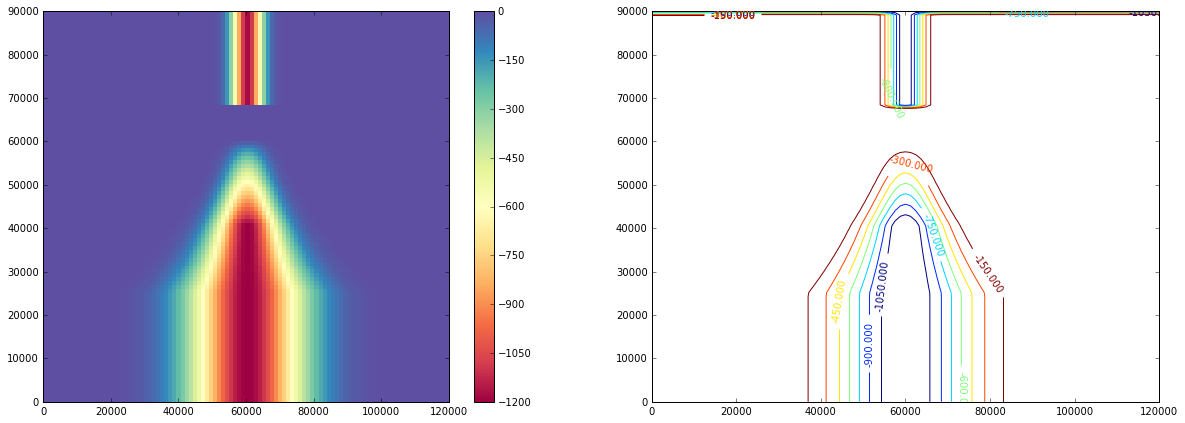

In [9]:
# z's have to be positive
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,7)) 
p = ax1.pcolormesh(x, y, topography, cmap=cm.Spectral)
fig.colorbar(p, ax=ax1)

c = ax2.contour(x, y, topography)
ax2.clabel(c, inline=1, fontsize=10, cmap=cm.Spectral)

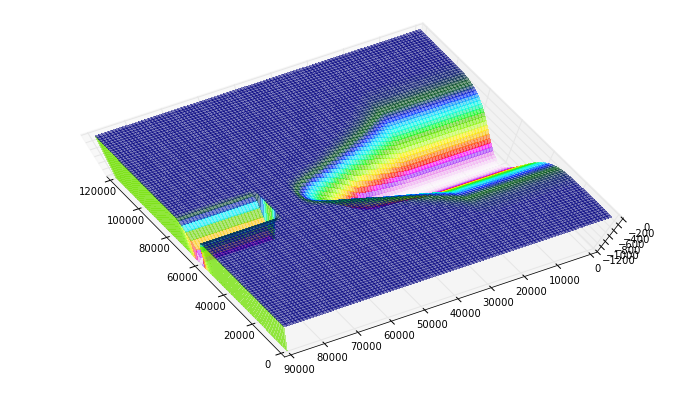

In [10]:
fig = plt.figure(figsize=(12,7))
ax3 = fig.add_subplot(1, 1, 1, projection='3d')
X, Y = np.meshgrid(x, y)
surf = ax3.plot_surface(X, Y, topography, rstride=1, cstride=1, cmap=cm.gist_ncar_r, linewidth=0, antialiased=False, alpha=0.5)
ax3.view_init(elev=80, azim=150)

## Continental Slope

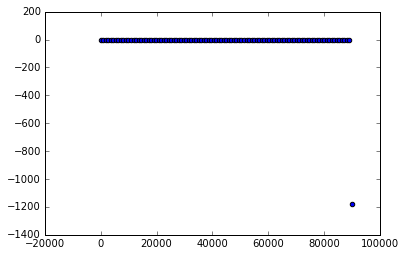

In [11]:
slope_profile = tanktopo(total_fluid_depth,y,y_base,y_bc,y_sb,y_coast,z_bottom,z_bc,z_sb,z_wall)
plt.scatter(y, slope_profile)

## Re-make

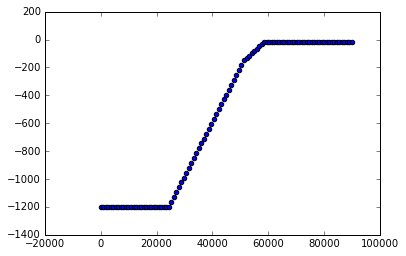

In [12]:
# cross-shore direction
no_canyon_topography = np.zeros(len(y))
continental_slope_profile = np.zeros(len(y))

y_base = 25 * 1000 # distance to bottom of continental slope (depth 1200 m)
y_break = 52 * 1000 # distance to the shelf break
y_coast = 59 * 1000 # where shelf flattens out
z_base = -1200 # depth of basin
z_break = -150 # depth at shelf break
z_coast = -20 # depth of flat shelf

# slope of lines
m_base_break = (z_break - z_base)/(y_break - y_base)
m_break_coast = (z_coast - z_break)/(y_coast - y_break)

for i in np.arange(len(y)):
    # continental slope
    if y[i] > y_base and y[i] <= y_break:
        no_canyon_topography[i] = m_base_break * (y[i] - y[i-1]) + no_canyon_topography[i-1]
    # varying shelf
    elif y[i] > y_break and y[i] <= y_coast:
        no_canyon_topography[i] = m_break_coast * (y[i] - y[i-1]) + no_canyon_topography[i-1]
    # flat shelf
    elif y[i] > y_coast:
        no_canyon_topography[i] = no_canyon_topography[i-1]
    # make depths negative
    continental_slope_profile[i] = no_canyon_topography[i] + z_base
    
plt.scatter(y, continental_slope_profile)

## Canyon

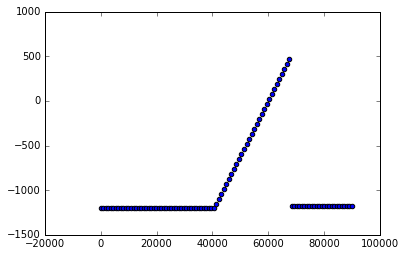

In [13]:
canyon_profile = canyontopo(total_fluid_depth, L, y, y_sb, y_coast, z_sb, z_wall)
plt.scatter(y, canyon_profile)

## Re-make

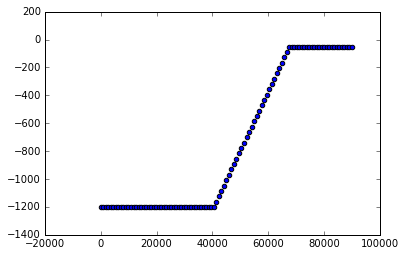

In [14]:
# cross-shore direction
canyon_topography = np.zeros(len(y))
canyon_slope_profile = np.zeros(len(y))

y_base_axis = 40700   # distance to 1200 m contour along canyon axis
y_break = 52 * 1000 # distance to the shelf break
y_coast = 59 * 1000 # where shelf flattens out
canyon_length = 16180 # canyon length
y_head = y_break + canyon_length # distance to the canyon head
z_base = -1200 # depth of basin
z_head = -30 # depth at head (different from z_break)
z_coast = -20 # depth of flat shelf

# slope of lines
m_base_axis_head = (z_head - z_base)/(y_head - y_base_axis)
m_head_coast = (z_coast - z_head)/(y_coast - y_head)

# along canyon axis
for i in np.arange(len(y)):
    # incised continental slope
    if y[i] > y_base_axis and y[i] <= y_head:
        canyon_topography[i] = m_base_axis_head * (y[i] - y[i-1]) + canyon_topography[i-1]
    # varying shelf
    elif y[i] > y_head and y[i] <= y_coast:
        canyon_topography[i] = m_head_coast * (y[i] - y[i-1]) + canyon_topography[i-1]
    # flat shelf
    elif y[i] > y_coast:
        canyon_topography[i] = canyon_topography[i-1]
    # make depths negative
    canyon_slope_profile[i] = canyon_topography[i] + z_base

        
plt.scatter(y, canyon_slope_profile)

## Width

In [18]:
z_sb = 150 # depth at shelf break (--) * good
# depth at canyon head 30 m different for flat shelf where 150 m
# depth drop across canyon 950
z_bottom = 1200 # depth of basin (depth of deep ocean)
Wsb =  13005 # width at shelf break (--) * good
W = 7660 # width at mid-canyon (--) * good
L = 16180 # canyon length (--)
x_wall = 120 * 1000 # alongshore direction (width of the ocean basin) * good
y_wall = 90 * 1000 # cross-shore direction (length of the ocean basin)
y_base = 25 * 1000 # (distance where slope begins to rise from bottom) * ???? 25
y_bc = 52 * 1000 # (distance to canyon mouth) * NO EFFECT?
y_sb = 52 * 1000 # (distance to the shelf break) * makes the stem disappear when increased to 75 // y_wall - (45 * 1000)
y_coast = 59 * 1000 # (distance to where topo stops increasing but not 0) * shape of the stem // y_wall - (20 * 1000)
z_bc = 1000 # (depth of 1000 m contour) ???????????? any difference????
z_wall = 20 # minimum ocean depth (depth of topo beyond y_coast) * ??????
total_fluid_depth = z_bottom
p = 1
# cR,p,x,y
# make radius of curvature go to infinity for non-tank so sigmaa=0
# p is just something like 1
x = np.linspace(0, x_wall, 101)
y = np.linspace(0, y_wall, 101)

In [25]:
y_base = 25 * 1000 # distance to bottom of continental slope (depth 1200 m)
y_break = 52 * 1000 # distance to the shelf break
canyon_length = 16180 # canyon length
y_head = y_break + canyon_length # distance to the canyon head

w_break =  13005 # width at shelf break (Wsb)
w_midcanyon = 7660 # width at mid-canyon (W)
w_head = 0.0295 * w_break # (Wh)
sigma = 0
width = np.zeros(len(y))

half = 0.5 * (w_midcanyon - w_break) # width halfway between mid-canyon and shelf break
e = (canyon_length / 2.0)/half #parameter here
alpha = y_break/y_base


    #e = (L/2.0 -sigmaa*half**2)/half**p
    #sc = 1
    #alphaa = y_sb/y_base
    
    #y90 = y_sb+0.062423*L
    #W90 = Wsb-0.06651*Wsb
    #dG_dx90 = p*e*(W90 - Wsb/2)**(p - 1) + 2*sigmaa*(W90 - Wsb)
    #dW90 = 0.5/dG_dx90/sc
    #A90 = (alphaa*Wsb-W90)/(y_base-y90)**2 - dW90/(y_base-y90)

    #Wh = Wsb-0.9705*Wsb
    #dG_dxh = p*e*(Wh - Wsb/2)**(p - 1) + 2*sigmaa*(Wh - Wsb)
    #dh = 0.5/dG_dxh/sc
    #Ah = (alphaa*Wsb-Wh)/(y_base-(y_sb+L))**2; #- dh/(y_base-(y_sb+L))


    

Ah = ((alpha) * w_break - w_head)/(y_base - y_head)**2
dh = 0.5 / e

for i in np.arange(len(y)):
    
    # deep ocean outside of the canyon
    if y[i] <= y_base:
        width[i] = x_wall # total width of domain
    
    # full canyon
    elif y[i] > y_base and y[i] <= y_head:
        width[i] = Ah*(y[i]-(y_head))**2 + dh*(y[i]-(y_head))+ w_head + 9000
    
    # shelf beyond canyon head
    elif y[i] > y_head:
        width[i] = 0 # no width because canyon is done
        
width_profile_test = width  

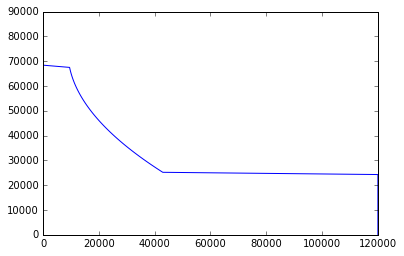

In [26]:
plt.plot(width_profile_test, y)

In [29]:
y_base = 25 * 1000 # distance to bottom of continental slope (depth 1200 m)
y_break = 52 * 1000 # distance to the shelf break
canyon_length = 16180 # canyon length
y_head = y_break + canyon_length # distance to the canyon head

w_break =  13005 # width at shelf break (Wsb)
w_midcanyon = 7660 # width at mid-canyon (W)
w_head = 0.0295 * w_break # (Wh)
width = np.zeros(len(y))
half = 0.5 * (w_midcanyon - w_break) # width halfway between mid-canyon and shelf break


Ah = ((y_break/y_base) * w_break - w_head)/(y_base - y_head)**2
e = (canyon_length / 2.0)/half
dh = 0.5 / e

for i in np.arange(len(y)):
    
    # deep ocean outside of the canyon
    if y[i] <= y_base:
        width[i] = x_wall # total width of domain
    
    # full canyon
    elif y[i] > y_base and y[i] <= y_head:
        width[i] = Ah*(y[i]-(y_head))**2 + dh*(y[i]-(y_head))+ w_head + 9000
    
    # shelf beyond canyon head
    elif y[i] > y_head:
        width[i] = 0 # no width because canyon is done
        
width_profile = width  

## Full

In [30]:
slope_profile = tanktopo(total_fluid_depth,y,y_base,y_bc,y_sb,y_coast,z_bottom,z_bc,z_sb,z_wall)
canyon_profile = canyontopo(total_fluid_depth, L, y, y_sb, y_coast, z_sb, z_wall)

canyondepth = slope_profile - canyon_profile
canyondepth[canyondepth < 0] = 0

topography = np.zeros((len(y),len(x)))

for j in np.arange(len(x)):
    topography[:,j] = (slope_profile-canyondepth*(1.0/(np.cosh(0.455/width_profile*(x[j]-(0.5*x_wall))))**50))

/home/imachuca/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide
/home/imachuca/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply


<a list of 21 text.Text objects>

/home/imachuca/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


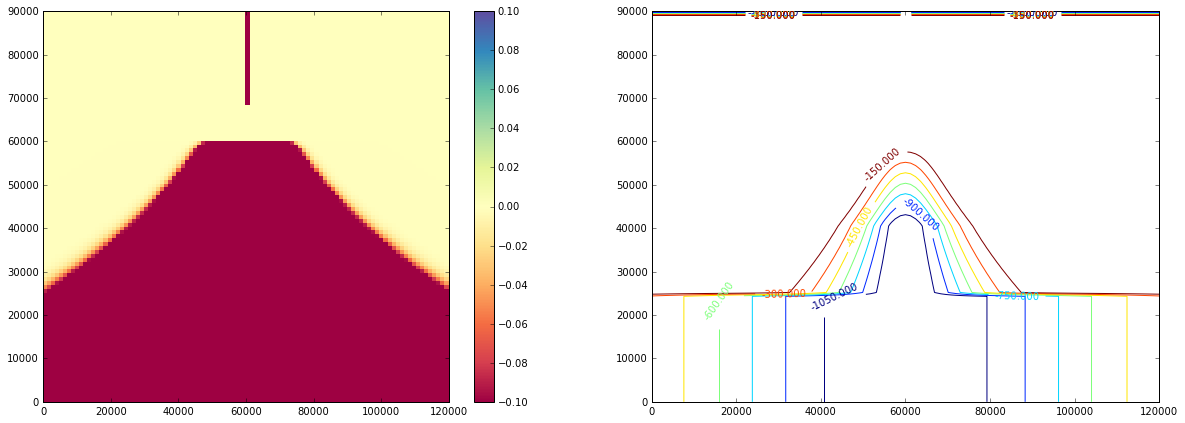

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,7)) 
p = ax1.pcolormesh(x, y, topography, cmap=cm.Spectral)
fig.colorbar(p, ax=ax1)

c = ax2.contour(x, y, topography)
ax2.clabel(c, inline=1, fontsize=10, cmap=cm.Spectral)

In [ ]:
from IPython.display import Image
Image(filename='../../images/Spurgin_canyon.png')